# 0) Loading Data to VM and setting up the notebook

In [ ]:
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt, tqdm, json, os, math

ROOT = Path("data/lmd_matched").expanduser()
midi_files = sorted(ROOT.rglob("*.mid")) + sorted(ROOT.rglob("*.midi"))
print("Number of MIDIs:", len(midi_files))
print("Here are three examples:", midi_files[:3])

Number of MIDIs: 116189
Here are three examples: [WindowsPath('data/lmd_matched/A/A/A/TRAAAGR128F425B14B/1d9d16a9da90c090809c153754823c2b.mid'), WindowsPath('data/lmd_matched/A/A/A/TRAAAGR128F425B14B/5dd29e99ed7bd3cc0c5177a6e9de22ea.mid'), WindowsPath('data/lmd_matched/A/A/A/TRAAAGR128F425B14B/b97c529ab9ef783a849b896816001748.mid')]


# Basic integrity

## A glimpse into the type of music

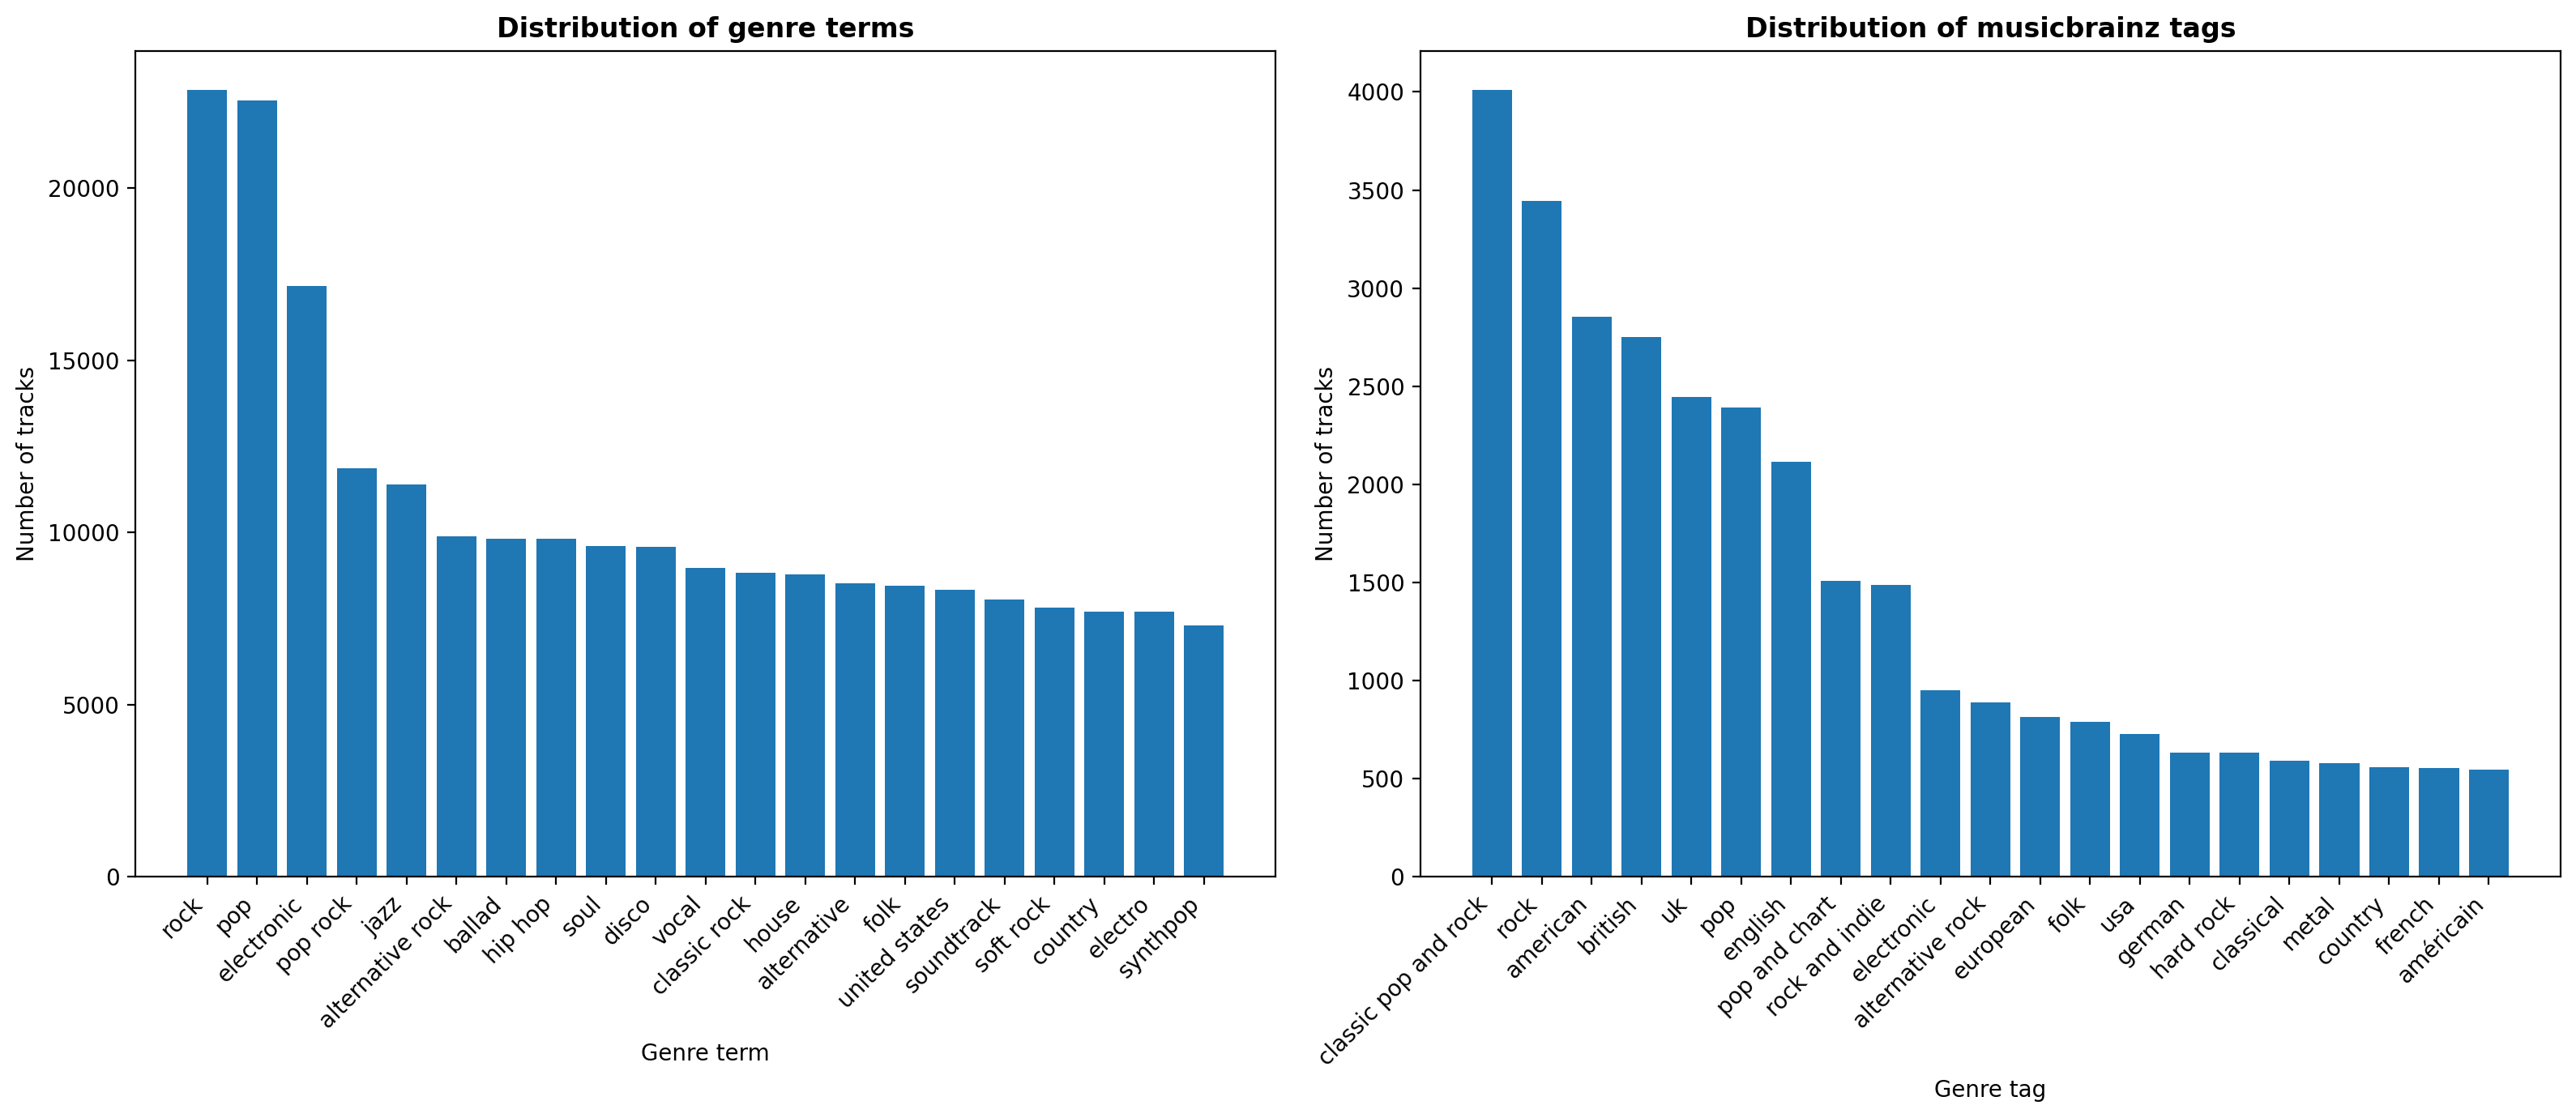

In [ ]:
terms_distro = pd.read_csv("data/term_distro.csv", delimiter=",")
mbtags_distro = pd.read_csv("data/mbtag_distro.csv", delimiter=",")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), tight_layout=True)

ax1.bar(terms_distro["genre_term"].loc[:20], terms_distro["n_tracks"].loc[:20])
ax1.set_title("Distribution of genre terms", fontweight="bold")
ax1.set_ylabel("Number of tracks")
ax1.set_xlabel("Genre term")
ax1.tick_params(axis="x", labelrotation=45)
for t in ax1.get_xticklabels():
    t.set_ha("right")

ax2.bar(mbtags_distro["genre_tag"].loc[:20], mbtags_distro["n_tracks"].loc[:20])
ax2.set_title("Distribution of musicbrainz tags", fontweight="bold")
ax2.set_ylabel("Number of tracks")
ax2.set_xlabel("Genre tag")
ax2.tick_params(axis="x", labelrotation=45)
for t in ax2.get_xticklabels():
    t.set_ha("right")
plt.show()

In [35]:
import pretty_midi, random, statistics
from tqdm import tqdm

rng = random.Random(0)
sample = rng.sample(midi_files, k=min(2000, len(midi_files)))


def safe_read(p):
    try:
        pm = pretty_midi.PrettyMIDI(str(p))
        return pm
    except Exception as e:
        return None


rows = []
for p in tqdm(sample):
    pm = safe_read(p)
    ok = pm is not None
    dur = pm.get_end_time() if ok else np.nan
    tempos = [] if not ok else [t for t in pm.get_tempo_changes()[1]]
    time_sigs = (
        []
        if not ok
        else [(ts.numerator, ts.denominator) for ts in pm.time_signature_changes]
    )
    n_notes = 0 if not ok else sum(len(i.notes) for i in pm.instruments)
    n_instr = 0 if not ok else len(set([i.program for i in pm.instruments]))
    rows.append(
        dict(
            path=str(p),
            ok=ok,
            duration=dur,
            notes=n_notes,
            instruments=n_instr,
            tempi=len(tempos),
            time_sigs=len(time_sigs),
        )
    )
df_basic = pd.DataFrame(rows)
df_basic.head()

  0%|          | 1/2000 [00:00<05:26,  6.12it/s]c:\ProgramData\anaconda3\envs\bachelor-thesis\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
100%|██████████| 2000/2000 [03:12<00:00, 10.39it/s]


,path,ok,duration,notes,instruments,tempi,time_sigs
0,data\lmd_matched\Y\S\G\TRYSGFN128F428CDDD\148d...,True,233.836803,10161,10,1,0
1,data\lmd_matched\K\W\L\TRKWLUC12903CDF4AD\7945...,True,190.165530,4305,10,1,2
2,data\lmd_matched\W\C\G\TRWCGDC128F146F672\54e1...,True,248.020933,8643,13,1,1
3,data\lmd_matched\L\V\H\TRLVHPH128E07929AA\b437...,True,194.000000,3493,5,1,1
4,data\lmd_matched\B\C\Q\TRBCQLR12903D11151\9b35...,True,199.760236,3029,9,1,1


In [42]:
print( df_basic['ok'].mean(), "MIDIs that have been successfully read")
print()
print("Duration statistics:")
print(df_basic['duration'].describe())
print()
print("Notes statistics:")
print(df_basic['notes'].describe())
print()
print("Instruments statistics:")
print(df_basic['instruments'].describe())

0.9885 MIDIs that have been successfully read

Duration statistics:
count    1977.000000
mean      229.442769
std        80.555471
min        30.463985
25%       188.897260
50%       228.244594
75%       267.006250
max      2036.666304
Name: duration, dtype: float64

Notes statistics:
count     2000.000000
mean      4778.323500
std       2822.236649
min          0.000000
25%       2762.500000
50%       4414.500000
75%       6392.000000
max      17389.000000
Name: notes, dtype: float64

Instruments statistics:
count    2000.000000
mean        7.738500
std         3.735384
min         0.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        38.000000
Name: instruments, dtype: float64
